# Binary black hole initial data

SpECTRE includes an initial data solver for high-spin and very accurate binary
black hole initial data. The initial data can be used to seed evolutions of
merging black holes with SpECTRE or other evolution codes, e.g. based on
excisions or moving punctures. Some features of the initial data include:

- **High spins**: Black holes can be imbued with spins up to $\sim 0.994$, which
  are the highest spins that have been achieved to [date](???). Note that this
  number refers to the _relaxed_ dimensionless spins measured after a bit of
  evolution, after the initial transient of spurious junk radiation has passed.
- **Low junk radiation:** We minimize junk radiation to achieve high spins by
  solving on a curved conformal background, which is built from a superposition
  of Kerr black holes. This is necessary because not even the Kerr solution has
  conformally flat slices, so we cannot hope to achieve high-spin binary initial
  data in conformal flatness.
- **No symmetries:** Spins can be arbitrarily oriented with respect to the
  orbital angular momentum and each other, allowing for precessing binaries.
- **XCTS formulation:** We solve for the equilibrium lapse and shift in addition
  to the conformal factor, providing a possible coordinate choice to start the
  evolution.
- **Excision:** Black holes are represented as excised regions in the initial
  data. The excisions are ellipsoids of constant Boyer-Lindquist radius to
  account for spinning black holes. The excisions are placed slightly _inside_
  the horizons by using _negative-expansion boundary conditions_, so the
  horizons are always well resolved. No extrapolation into the excisions is
  needed to start an evolution that also uses an excision method. For evolutions
  that use a moving puncture method we provide an extrapolation routine to fill
  the excisions.
- **Interpolation:** The initial data can be interpolated to any given set of
  coordinates to start an evolution.
- **Parameter control:** We provide a method to precisely control the masses,
  spins, and other parameters by repeated initial data solves.
- **Eccentricity control:** We also provide a method to control the orbital
  eccentricity. This requires an evolution, which can be done with SpECTRE or
  another evolution code.

To generate initial data you need a copy of the `SolveXcts` executable. You can
obtain it in the following ways:
- **Container:** if you have [Docker]() or [Apptainer/Singularity]() available
  on your workstation or cluster, then the container is a very easy way to run
  the code. Just run the following command:

  ```sh
  # Docker
  docker run sxscollaboration/spectre bbh generate-id --help
  # Apptainer/Singularity
  apptainer run docker://sxscollaboration/spectre bbh generate-id --help
  ```

  The container will download and execute the `generate-id` command-line
  interface (CLI).
- **Precompiled executables:** on supported systems (Linux with a reasonably
  recent CPU) you can download the precompiled executables that we distribute
  with every release. Run them like this:

  ```sh
  SolveXcts --input-file INPUT_FILE
  ```

  This doesn't get you access to the `generate-id` tool, so you have to copy and
  edit your own YAML input files.
- **Compile yourself:** follow the [installation instructions]() to configure a
  SpECTRE build and compile the targets `SolveXcts` and `cli`. Also compile the
  target `BundledExporter` if you want to import the data into another code.
  Run the following command in the build directory:

  ```sh
  spectre bbh generate-id --help
  ```

In the following we use the Python interface, but all command are also available
from command line.

In [1]:
import h5py
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rich
import yaml
from pathlib import Path
from spectre.Visualization.Plot import DEFAULT_MPL_STYLESHEET

plt.style.use(DEFAULT_MPL_STYLESHEET)

In [2]:
# We will generate initial data in this directory.
run_dir = Path("runs/InitialData")

## Generate initial data

Use the `spectre bbh generate-id` command of the BBH pipeline to run the initial
data solver. It is also available in Python as the `generate_id` function:

In [3]:
from spectre.Pipelines.Bbh.InitialData import generate_id

The function will generate an input file for the `SolveXcts` executable based on
your input parameters and run it.

Alternatively, you can copy the input file in
`support/Pipelines/Bbh/InitialData.yaml`, edit it manually, and run `SolveXcts
--input-file InitialData.yaml`.

The initial data solve will take ~5 minutes to run on 32 cores, which is what we
have available on Oscar. It will be faster if you have more cores available.

Here's an example to generate equal-mass nonspinning BBH initial data:

In [8]:
generate_id(
    # Intrinsic parameters
    mass_a=0.5,
    mass_b=0.5,
    dimensionless_spin_a=[0, 0, 0],
    dimensionless_spin_b=[0, 0, 0],
    # Orbital parameters
    # (you can get a low-eccentricity estimate from
    # `spectre.Pipelines.EccentricityControl.InitialOrbitalParameters`)
    separation=16.0,
    orbital_angular_velocity=0.015,
    radial_expansion_velocity=0.0,
    # Output files will be written to this directory
    run_dir=run_dir,
    # Parameter control
    # (enable to drive horizon masses and spins to the values above)
    control=False,
    # Scheduling options
    # scheduler: 'None' to run directly or 'sbatch' to submit a job on a
    # supported cluster
    scheduler="sbatch",
    submit=True,
    time_limit="01:00:00",
)

The BBH pipeline is still experimental. Please review the generated input files.


CompletedProcess(args=['sbatch', 'Submit.sh'], returncode=0, stdout='Submitted batch job 4027956\n', stderr='')

> **On the command line:** Try `spectre bbh generate-id --help`.

In [4]:
%%bash
# Check status of your job
export COLUMNS=150
spectre status

EvolveGhBinaryBlackHole ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

 State      End             JobID    JobName               Elapsed   Cores  Nodes  Time [M]  Speed [M/h]  Orbits   Separation [M]  3-Index Constraint 
 CANCELLED  today 13:23:55  4025979  EvolveGhBinaryBlack…  17:31:04  32     1      208.5     10.6345      1.24677  6.7119          8.90e-05           

SolveXcts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

 State      End             JobID    JobName    Elapsed   Cores  Nodes  Nonlinear iteration  Nonlinear residual  Linear iteration  Linear residual 
 COMPLETED  today 15:17:48  4027956  SolveXcts  00:06:22  32     1      6                    7.9e-10             69                7.9e-10         


## Plot the output

The result of the initial data solve is written to a set of H5 files in the
`run_dir`. We will use sample initial data here, but you can point this to your
generated data as well:

In [5]:
%%bash
export ID_DIR=/oscar/data/icerm/nvu8/05_Friday/InitialData

ls $ID_DIR

BbhReductions.h5
BbhVolume0.h5
BbhVolume1.h5
Horizons.h5
InitialData.yaml
jobid.txt
spectre.out
Submit.sh


We can do a quick plot using the `plot_slice` tool.

> **One the command line:** the `plot_slice` tool is available on the command
> line as `spectre plot slice --help`. Many more tools to do quick plots are
> available in the `spectre plot` subcommand.

In [6]:
run_dir = Path("/oscar/data/icerm/nvu8/05_Friday/InitialData")

In [7]:
from spectre.Visualization.PlotSlice import plot_slice
from spectre.Visualization.ReadH5 import list_observations
from spectre.Visualization.OpenVolfiles import open_volfiles

In [8]:
with open(run_dir / "InitialData.yaml", "r") as open_input_file:
    _, input_file = yaml.safe_load_all(open_input_file)

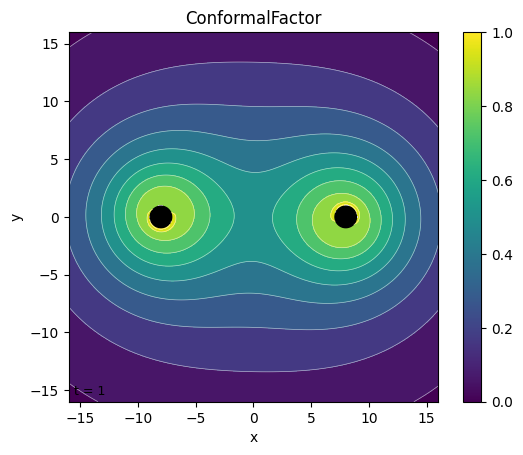

In [9]:
h5files = glob.glob(str(run_dir / "BbhVolume*.h5"))
obs_ids, obs_times = list_observations(open_volfiles(h5files, "VolumeData"))
_ = plot_slice(
    h5files,
    subfile_name="VolumeData",
    obs_id=obs_ids[-1],
    obs_time=obs_times[-1],
    var_name="ConformalFactor",
    slice_origin=[0, 0, 0],
    slice_extent=[32, 32],
    slice_normal=[0, 0, 1],
    slice_up=[0, 1, 0],
)


# Plot excisions
def plot_excisions():
    excision_radius = input_file["DomainCreator"]["BinaryCompactObject"]["ObjectA"][
        "InnerRadius"
    ]
    phi = np.linspace(0, 2 * np.pi, 100)
    for xcoord in input_file["Background"]["Binary"]["XCoords"]:
        excision_xy = np.array(
            [excision_radius * np.cos(phi), excision_radius * np.sin(phi)]
        )
        excision_xy[0] += xcoord
        plt.gca().add_patch(
            plt.Polygon(
                excision_xy.T,
                facecolor="black",
                fill=True,
                edgecolor="black",
                linewidth=1,
            )
        )


plot_excisions()

## Find horizons in the initial data

Apparent horizons are automatically found in the initial data after the solve is
complete, and written to a `Horizons.h5` file:

In [10]:
from spectre.Visualization.ReadH5 import to_dataframe

In [11]:
with h5py.File(run_dir / "Horizons.h5", "r") as open_horizons_file:
    AhA = to_dataframe(open_horizons_file["AhA.dat"])
AhA

,Area,IrreducibleMass,MaxRicciScalar,MinRicciScalar,ChristodoulouMass,DimensionlessSpinMagnitude,DimensionlessSpinVector_x,DimensionlessSpinVector_y,DimensionlessSpinVector_z
0,20.100612,0.632368,1.252302,1.249242,0.632368,0.002001,9.682144e-08,3.063896e-08,-0.002001


We can also find a horizon in the initial data by running the horizon finder:

In [12]:
from spectre.Pipelines.Bbh.FindHorizon import find_horizon
from spectre.SphericalHarmonics import Strahlkorper, cartesian_coords

In [13]:
horizon_shape, horizon_quantities = find_horizon(
    h5files,
    subfile_name="VolumeData",
    obs_id=obs_ids[-1],
    obs_time=obs_times[-1],
    initial_guess=Strahlkorper(l_max=12, radius=1.0, center=[8, 0, 0]),
)
rich.print(horizon_quantities)

{
    'Area': 20.10061085764441,
    'IrreducibleMass': 0.6323677309486081,
    'MaxRicciScalar': 1.2523019813618146,
    'MinRicciScalar': 1.2492421668245195,
    'ChristodoulouMass': 0.6323680474437895,
    'DimensionlessSpinMagnitude': 0.0020009826093375887,
    'DimensionlessSpinVector': [9.682143731571308e-08, 3.0638963018783325e-08, -0.0020009826067605707]
}

Here's the shape of the excision and of the apparent horizon in the initial
data:

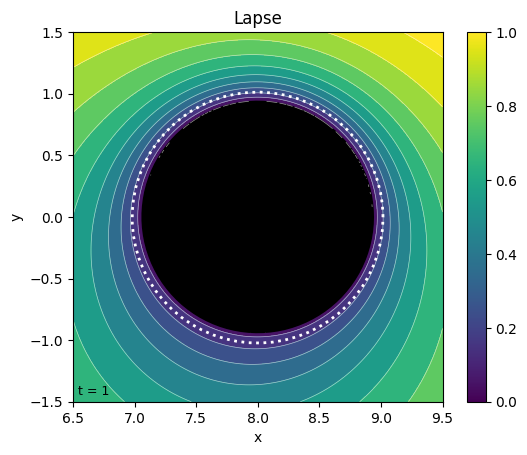

In [15]:
_ = plot_slice(
    h5files,
    subfile_name="VolumeData",
    obs_id=obs_ids[-1],
    obs_time=obs_times[-1],
    var_name="Lapse",
    slice_origin=[8, 0, 0],
    slice_extent=[3, 3],
    slice_normal=[0, 0, 1],
    slice_up=[0, 1, 0],
)
# Plot excision
excision_radius = input_file["DomainCreator"]["BinaryCompactObject"]["ObjectA"][
    "InnerRadius"
]
phi = np.linspace(0, 2 * np.pi, 100)
excision_xy = np.array(
    [excision_radius * np.cos(phi), excision_radius * np.sin(phi)]
)
excision_xy[0] += 8
plt.gca().add_patch(
    plt.Polygon(
        excision_xy.T,
        facecolor="black",
        fill=True,
        edgecolor="black",
        linewidth=2.5,
    )
)
# Plot horizon
horizon_xyz = np.array(cartesian_coords(Strahlkorper(32, 32, horizon_shape)))
horizon_xy = horizon_xyz[:2, np.abs(horizon_xyz[2]) < 1e-14]
plt.gca().add_patch(
    plt.Polygon(
        horizon_xy.T,
        fill=False,
        edgecolor="white",
        linewidth=2.0,
        linestyle="dotted",
    )
);

You can see that the initial data extends slightly into the apparent horizon. We
do this by imposing _negative-expansion boundary conditions_ on the excision
boundary. Specifically, we do this:

1. Choose the excision surface $\mathcal{S}$ as the ellipsoid with constant
   Boyer-Lindquist radius $R_\mathrm{BL}=0.94 \, r_+$ in Kerr-Schild
   coordinates, where $r_+$ is the outer Kerr horizon of the isolated solution
   with the given masses and spins.
2. Impose the _expansion_ on the excision surface has the value
   $\Theta=\Theta_\mathrm{Kerr}$, where $\Theta_\mathrm{Kerr}$ is the expansion
   of the isolated Kerr solution evaluated on $\mathcal{S}$. This value will be
   negative, because $\mathcal{S}$ is slightly inside the apparent horizon of
   the isolated Kerr solution.

## Start an evolution: interpolate and extrapolate the data

To start an evolution from the generated initial data we have to interpolate to
the evolution grid, which is often completely different from the initial data
grid. You typically want to interpolate the spatial metric $\gamma_{ij}$ and the
extrinsic curvature $K_{ij}$, and possibly also the lapse $\alpha$ and the shift
$\beta^i$.

In SpECTRE this is supported natively by the `EvolveBinaryBlackHole` executable.
You just set the `InitialData` section of the input file to `NumericInitialData`
and specify paths to the initial data files (see `Inspiral.yaml` for an
example). We have used this in the BBH pipeline on Monday.

To import the initial data into another evolution code, you have the following
options:

### 1) Interpolate in Python

Use the `interpolate_to_points` or `interpolate_tensors_to_points` function.
They only differ in how they handle tensor components:

- `interpolate_to_points` takes individual tensor components like
  `tensor_components=["SpatialMetric_xx", ...]` and returns a list of all
  interpolated components.
- `interpolate_tensors_to_points` works with our tensor types, so it takes
  `tensor_names=["SpatialMetric", ...]` and
  `tensor_types=[tnsr.ii[DataVector, 3], ...]` and also returns a list of
  tensors.

Tensors easily convert to numpy arrays, so we recommend to use
`interpolate_tensors_to_points` unless you want to interpolate only specific
components.

In [16]:
from spectre.IO.Exporter import interpolate_tensors_to_points
from spectre.DataStructures.Tensor import tnsr, Scalar, DataVector

In [17]:
# Create a Cartesian grid of points
x, y = np.meshgrid(
    np.linspace(-16, 16, 200),
    np.linspace(-16, 16, 200),
)
z = np.zeros(x.shape)

# Interpolate!
spatial_metric, extrinsic_curvature, lapse, shift = interpolate_tensors_to_points(
    h5files,
    subfile_name="VolumeData",
    observation_id=obs_ids[-1],
    tensor_names=["SpatialMetric", "ExtrinsicCurvature", "Lapse", "Shift"],
    tensor_types=[
        tnsr.ii[DataVector, 3],
        tnsr.ii[DataVector, 3],
        Scalar[DataVector],
        tnsr.I[DataVector, 3],
    ],
    target_points=[x.flatten(), y.flatten(), z.flatten()],
)

This is the order of components in the returned tensors:

In [18]:
for i in range(len(spatial_metric)):
    print("SpatialMetric" + spatial_metric.component_suffix(i))

SpatialMetric_xx
SpatialMetric_yx
SpatialMetric_zx
SpatialMetric_yy
SpatialMetric_zy
SpatialMetric_zz


/oscar/data/icerm/knelli/software/spectre-python/lib/python3.9/site-packages/numpy/ma/core.py:1183: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)


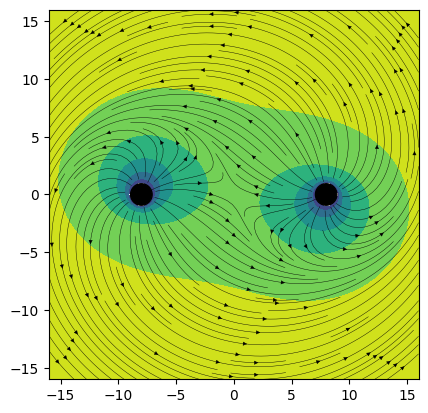

In [19]:
# Plot lapse contours
plt.contourf(x, y, np.reshape(lapse, x.shape))
# Plot shift streamlines
plt.streamplot(
    x,
    y,
    np.reshape(shift[0], x.shape),
    np.reshape(shift[1], x.shape),
    linewidth=0.3,
    color="black",
    arrowsize=0.6,
    density=2,
)
plot_excisions()
plt.gca().set_aspect("equal")

### 2) Interpolate on the command line

You can also create a file with all the coordinates you want to interpolate to
and pass it to the command-line tool `spectre interpolate-to-points`. It will
output a file with the interpolated variables:

In [20]:
coords = np.array([x.flatten(), y.flatten(), z.flatten()]).T
print("Shape of coordinates array: ", coords.shape)
np.savetxt("runs/coords.dat", coords)
# Pass this file to `spectre interpolate-to-points`.

Shape of coordinates array:  (40000, 3)


In [21]:
%%bash
export ID_DIR=/oscar/data/icerm/nvu8/05_Friday/InitialData

spectre interpolate-to-points $ID_DIR/BbhVolume*.h5 \
    -y Lapse -y "Shift_*" -y "SpatialMetric_*" -y "ExtrinsicCurvature_*" \
    --step -1 -t runs/coords.dat -o runs/interpolated.dat

[16:05:21] INFO     Selected subfile /VolumeData.vol (the    ]8;id=73385;file:///users/nvu8/spectre/build/bin/python/spectre/Visualization/OpenVolfiles.py\OpenVolfiles.py]8;;\:]8;id=399968;file:///users/nvu8/spectre/build/bin/python/spectre/Visualization/OpenVolfiles.py#169\169]8;;\
                    only available one).                                        
           INFO     Selected observation step -1 at t = 1.         ]8;id=710987;file:///users/nvu8/spectre/build/bin/python/spectre/Visualization/ReadH5.py\ReadH5.py]8;;\:]8;id=222465;file:///users/nvu8/spectre/build/bin/python/spectre/Visualization/ReadH5.py#138\138]8;;\


In [22]:
%%bash
head runs/interpolated.dat

# t = 1
# X Y Z SpatialMetric_zz SpatialMetric_yy ExtrinsicCurvature_zx ExtrinsicCurvature_zz SpatialMetric_yx ExtrinsicCurvature_yy ExtrinsicCurvature_zy SpatialMetric_zx Lapse SpatialMetric_xx SpatialMetric_zy Shift_y ExtrinsicCurvature_yx Shift_x Shift_z ExtrinsicCurvature_xx
-1.600000000000000000e+01 -1.600000000000000000e+01 0.000000000000000000e+00 1.117505256353286347e+00 1.117505311499727316e+00 -9.163732782449228576e-09 9.549173818392220304e-04 2.171520909020288776e-08 -8.166674446884910872e-04 -2.113996947983350003e-09 0.000000000000000000e+00 9.483094871063695308e-01 1.117505265906762579e+00 0.000000000000000000e+00 -2.505591310159132057e-01 -1.341276162623969816e-03 2.279076273677083653e-01 -4.760613367555020691e-11 -1.382452789189647223e-04
-1.583919597989949679e+01 -1.600000000000000000e+01 0.000000000000000000e+00 1.118020529843663846e+00 1.118020591313405809e+00 -9.325840428879666763e-09 9.669451943941806361e-04 2.394695613216164930e-08 -8.455189243136478289e-04 -2.8465

### 3) Interpolate in your code

You can also call a C++ function from within your code to interpolate the data.
To do this, link the compiled `BundledExporter.so` library in your code and
include the `spectre/Exporter.hpp` header. You can find an example how to link
the library in `tests/Unit/IO/Exporter/BundledExporter/CMakeLists.txt`.

Then, call the C++ function `spectre::Exporter::interpolate_to_points`. It works
just like the Python functions shown above, in that you pass it the target
coordinates and it returns the interpolated data. See the file
`tests/Unit/IO/Exporter/BundledExporter/Test_BundledExporter.cpp` for an
example.

It is also possible to call C or Fortran bindings of this function. Get in touch
for more information.

### Extrapolate into the excisions for moving puncture codes

For moving puncture codes we have to fill the excisions. This can be done simply
by setting the `extrapolate_into_excisions` option of
`interpolate_tensors_to_points` or any of the alternatives listed above:

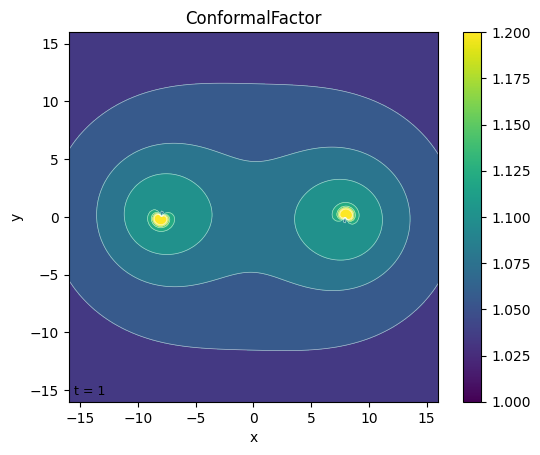

In [29]:
_ = plot_slice(
    h5files,
    subfile_name="VolumeData",
    obs_id=obs_ids[-1],
    obs_time=obs_times[-1],
    var_name="ConformalFactor",
    slice_origin=[0, 0, 0],
    slice_extent=[32, 32],
    slice_normal=[0, 0, 1],
    slice_up=[0, 1, 0],
    # Extrapolate into the excisions!
    extrapolate_into_excisions=True,
    data_bounds=(1, 1.2),
)

The extrapolation uses a 7th order polynomial extrapolation constructed from
anchor points on rings around the excision with $\Delta r = 0.3 r_H$, with $r_H$
the radius of the excision. This method is described in [Etienne](), though we
extend it work with our excisions that may not be spherical.